# **AI-Driven Protein Generation & Analysis on Colab**


This notebook follows the usage recommended by ProGen2 mirrors for Hugging Face:
- Loading via `AutoModelForCausalLM(..., trust_remote_code=True)`  
- **Tokenizer** via `tokenizers.Tokenizer.from_pretrained(...)` (and **not** `AutoTokenizer`)  
- Sequence-by-sequence generation, **without padding** (no `resize_token_embeddings`)

**Model**: `hugohrban/progen2-small` (mirror with custom code).  
**Goal**: demonstrate a minimal pipeline **ProGen2 → Analysis → Filtering →  3D**.


## Installing Dependencies

In [2]:
# Install/upgrade the required libraries
!pip -q install transformers>=4.41 tokenizers>=0.15 biopython pandas numpy matplotlib loguru py3Dmol biotite


## Imports & Utilities


In [4]:
from typing import Dict, List
import os, re, random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from loguru import logger

# Simple bio-utilities
KD = {"I":4.5,"V":4.2,"L":3.8,"F":2.8,"C":2.5,"M":1.9,"A":1.8,"G":-0.4,"T":-0.7,"S":-0.8,"W":-0.9,"Y":-1.3,"P":-1.6,"H":-3.2,"E":-3.5,"Q":-3.5,"D":-3.5,"N":-3.5,"K":-3.9,"R":-4.5}
AA = set("ACDEFGHIKLMNPQRSTVWY")

def seed_everything(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

def clean_seq(seq: str) -> str:
    """Remove non-alphabetic characters and keep only valid amino acids."""
    seq = re.sub(r"[^A-Za-z]", "", seq).upper()
    return "".join([c for c in seq if c in AA])

def aa_composition(seq: str) -> Dict[str, float]:
    """Return the amino acid composition of a sequence."""
    s = clean_seq(seq)
    tot = len(s) if len(s) > 0 else 1
    cnt = Counter(s)
    return {a: cnt.get(a, 0) / tot for a in sorted(list(AA))}

def kd_hydrophobicity(seq: str) -> float:
    """Compute the Kyte–Doolittle hydrophobicity score of a sequence."""
    s = clean_seq(seq)
    return float(np.mean([KD.get(a, 0.0) for a in s])) if s else 0.0

def net_charge_pH7(seq: str) -> float:
    """Estimate the net charge of a sequence at pH 7."""
    s = clean_seq(seq)
    pos = sum(s.count(a) for a in "KRH")
    neg = sum(s.count(a) for a in "DE")
    return float(pos - neg)

seed_everything(42)
logger.info("Utils ready.")


2025-08-14 07:45:53.775 | INFO     | __main__:<cell line: 0>:45 - Utils ready.


## Model Selection & Generation Brief


In [7]:
# Mirror model with custom code
MODEL_ID = "hugohrban/progen2-small"

# Brief (short prompt). The model is an AA-sequence LLM; the prompt acts as a primer.
BRIEF = "Design an enzyme for hydrolysis reactions, stable at high temperature, soluble, monomeric."

N_SAMPLES = 50        # number of sequences to generate
MAX_NEW_TOKENS = 256  # generated tokens (not exact AA count)
PROMPT_MAX_LEN = 128  # max prompt length (truncated if needed)

print(MODEL_ID)
print(BRIEF)


hugohrban/progen2-small
Design an enzyme for hydrolysis reactions, stable at high temperature, soluble, monomeric.


## Hugging Face Authentification

In [9]:

from huggingface_hub import login
login("hf_XXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

## Loading Model & Tokenizer (mirror usage doc)


In [10]:
import torch
from transformers import AutoModelForCausalLM
from tokenizers import Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"Device: {device}")

# Load model (custom code) + tokenizer (tokenizers.Tokenizer)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True).to(device).eval()
tok = Tokenizer.from_pretrained(MODEL_ID)
tok.no_padding()  # no padding

# eos_token_id if defined
eos_id = None
if hasattr(model, "config") and getattr(model.config, "eos_token_id", None) is not None:
    eos_id = model.config.eos_token_id

logger.info("ProGen2 loaded (mirror).")


2025-08-14 07:48:08.216 | INFO     | __main__:<cell line: 0>:6 - Device: cuda


config.json: 0.00B [00:00, ?B/s]

configuration_progen.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/hugohrban/progen2-small:
- configuration_progen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_progen.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/hugohrban/progen2-small:
- modeling_progen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-08-14 07:48:16.925 | INFO     | __main__:<cell line: 0>:18 - ProGen2 loaded (mirror).


## Sequence Generation (sequential, no padding)


In [31]:
def generate_sequences_llm(model, tok, brief: str, n_samples: int = 10,
                           max_new_tokens: int = 256, temperature: float = 0.9, top_p: float = 0.95,
                           prompt_max_len: int = 128) -> List[str]:
    import torch
    seqs = []
    for _ in range(n_samples):
        # Encode the brief without padding
        enc = tok.encode(brief[:prompt_max_len])
        input_ids = torch.tensor([enc.ids], dtype=torch.long, device=model.device)
        with torch.no_grad():
            out = model.generate(
                input_ids=input_ids,
                do_sample=True,
                temperature=temperature,
                top_p=top_p,
                max_new_tokens=max_new_tokens,
                eos_token_id=eos_id
            )
        out_ids = out[0].tolist()
        text = tok.decode(out_ids)
        # Remove the brief if repeated and clean to AA
        after = text.split(brief, 1)[-1] if brief in text else text
        cleaned = clean_seq(after)
        if len(cleaned) >= 20:
            seqs.append(cleaned)
    return seqs

seed_everything(42)
seqs = generate_sequences_llm(model, tok, BRIEF, n_samples=N_SAMPLES, max_new_tokens=MAX_NEW_TOKENS, prompt_max_len=PROMPT_MAX_LEN)
logger.info(f"{len(seqs)} candidate sequences generated (>=20 AA).")
seqs[:3]


## Saving in FASTA Format


In [12]:

import os
os.makedirs("outputs", exist_ok=True)
fasta_path = "outputs/progen_candidates.fasta"
with open(fasta_path, "w") as f:
    for i, s in enumerate(seqs, start=1):
        f.write(f">progen_cand_{i}\n{s}\n")
logger.info(f"FASTA saved to {fasta_path}")


2025-08-14 07:53:39.848 | INFO     | __main__:<cell line: 0>:7 - FASTA saved to outputs/progen_candidates.fasta


## 🔎 Analysis (length, hydrophobicity, charge, composition)


In [13]:

rows = []
for i, s in enumerate(seqs, start=1):
    comp = aa_composition(s)
    rows.append({
        "id": f"progen_cand_{i}",
        "sequence": s,
        "length": len(s),
        "kd_hydrophobicity": kd_hydrophobicity(s),
        "net_charge_pH7": net_charge_pH7(s),
        **{f"freq_{k}": v for k,v in comp.items()}
    })
df = pd.DataFrame(rows).set_index("id")
df.head(10)


,sequence,length,kd_hydrophobicity,net_charge_pH7,freq_A,freq_C,freq_D,freq_E,freq_F,freq_G,...,freq_M,freq_N,freq_P,freq_Q,freq_R,freq_S,freq_T,freq_V,freq_W,freq_Y
id,,,,,,,,,,,,,,,,,,,,,
progen_cand_1,DAEQLLKARNGGAAALLANPGNTAEVLKVADYAKSMGLKVLAEGSD...,147,0.302041,-4.0,0.190476,0.000000,0.074830,0.047619,0.006803,0.088435,...,0.006803,0.034014,0.027211,0.040816,0.027211,0.054422,0.047619,0.108844,0.000000,0.006803
progen_cand_2,DQTGLGGFAGISDEKMRNISESTGRTFADIRVAGGVMVNMAGPPFI...,257,-0.074319,0.0,0.124514,0.000000,0.066148,0.058366,0.027237,0.085603,...,0.027237,0.035019,0.054475,0.023346,0.038911,0.070039,0.058366,0.070039,0.000000,0.011673
progen_cand_3,DPSVSESKPSILSLRKSRLSGGIFQQEPQFLSKTEKRLAENTTVAD...,257,-0.596109,-1.0,0.070039,0.000000,0.066148,0.077821,0.007782,0.038911,...,0.000000,0.027237,0.081712,0.062257,0.019455,0.105058,0.097276,0.077821,0.000000,0.000000
progen_cand_4,DDHLTVGDLDSYLSQLYAKAEEENTYHVRTFIRHSSNLDHLSEIYS...,257,-0.380934,-12.0,0.077821,0.000000,0.070039,0.108949,0.027237,0.070039,...,0.000000,0.035019,0.027237,0.027237,0.062257,0.073930,0.050584,0.085603,0.000000,0.050584
progen_cand_5,DGARNFHVSTNPGGSLGKDHVLVGTQLKNTNAKGFLDVLQVVEADV...,257,-0.147082,-15.0,0.128405,0.000000,0.097276,0.019455,0.035019,0.143969,...,0.000000,0.073930,0.007782,0.015564,0.007782,0.089494,0.108949,0.077821,0.011673,0.031128
progen_cand_6,DLTGEDLRRLLIGEHGSVRPEDRAERSAPSWENIRRTAAAGFRRLY...,257,-0.267704,4.0,0.163424,0.007782,0.077821,0.054475,0.023346,0.081712,...,0.011673,0.003891,0.077821,0.015564,0.124514,0.054475,0.066148,0.062257,0.015564,0.007782
progen_cand_7,DRYGSVPVLGFHGAEDTTSPPLLIDGLTQGLADLGDTEGGHRSEER...,60,-0.841667,0.0,0.033333,0.016667,0.083333,0.083333,0.016667,0.150000,...,0.000000,0.000000,0.066667,0.016667,0.100000,0.083333,0.066667,0.050000,0.016667,0.033333
progen_cand_8,DETDGIGRMGIFVDVEAGSTDVYDLRNDGFSLGVRLPLYFEGSANE...,257,-0.244747,-7.0,0.062257,0.000000,0.077821,0.050584,0.058366,0.097276,...,0.007782,0.089494,0.035019,0.007782,0.027237,0.081712,0.070039,0.077821,0.000000,0.038911
progen_cand_9,DKILRRREALTDFRVVGRAESQEVSGFDSTPLGLDLERRELIEGLD...,257,-0.516342,1.0,0.085603,0.000000,0.062257,0.128405,0.007782,0.105058,...,0.000000,0.000000,0.023346,0.062257,0.186770,0.023346,0.011673,0.081712,0.000000,0.000000


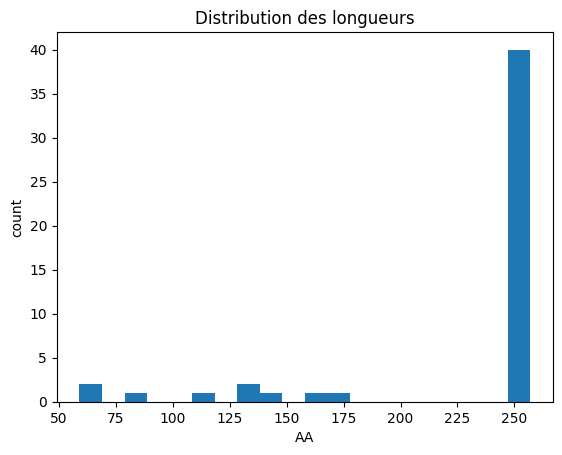

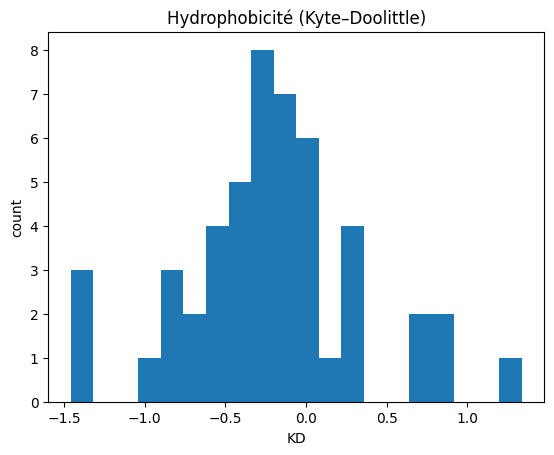

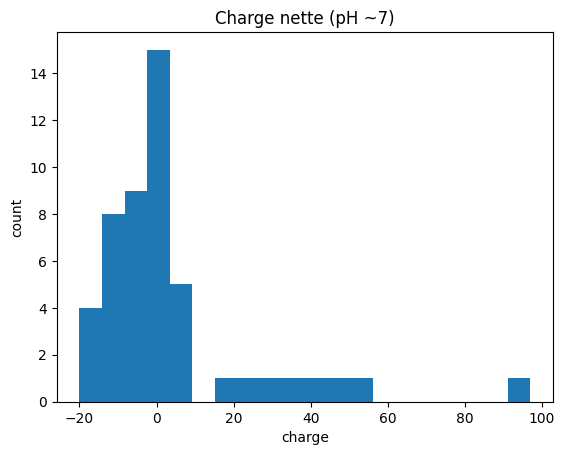

In [14]:

df["length"].plot(kind="hist", bins=20, title="Distribution des longueurs"); plt.xlabel("AA"); plt.ylabel("count"); plt.show()
df["kd_hydrophobicity"].plot(kind="hist", bins=20, title="Hydrophobicité (Kyte–Doolittle)"); plt.xlabel("KD"); plt.ylabel("count"); plt.show()
df["net_charge_pH7"].plot(kind="hist", bins=20, title="Charge nette (pH ~7)"); plt.xlabel("charge"); plt.ylabel("count"); plt.show()


## Filtering & Scoring (demonstration thresholds)

In this stage, the generated protein sequences are evaluated according to predefined biophysical criteria:  
- **Length**: only sequences within the desired amino acid count range are considered.  
- **Hydrophobicity**: sequences must fall within an acceptable Kyte–Doolittle hydrophobicity range.  
- **Net charge at pH 7**: sequences must have a balanced charge within specified limits.  

Each sequence is given a score based on how close its values are to the ideal midpoint of each range.  
The total score reflects the overall suitability of the sequence: the higher the score, the closer it matches the target profile.  

Finally, only the sequences that meet all the thresholds are kept, and they are ranked from the most to the least suitable according to their score.


In [15]:

LEN_MIN, LEN_MAX = 200, 400
KD_MIN, KD_MAX = -1.0, 2.0
CH_MIN, CH_MAX = -5, 5

def score_row(r) -> float:
    score = 0.0
    if LEN_MIN <= r["length"] <= LEN_MAX:
        score += 1.0 - abs((r["length"] - (LEN_MIN+LEN_MAX)/2) / (LEN_MAX-LEN_MIN))
    if KD_MIN <= r["kd_hydrophobicity"] <= KD_MAX:
        score += 1.0 - abs((r["kd_hydrophobicity"] - (KD_MIN+KD_MAX)/2) / (KD_MAX-KD_MIN))
    if CH_MIN <= r["net_charge_pH7"] <= CH_MAX:
        score += 1.0 - abs((r["net_charge_pH7"] - (CH_MIN+CH_MAX)/2) / (CH_MAX-CH_MIN))
    return float(score)

df["score"] = df.apply(score_row, axis=1)
mask = (
    df["length"].between(LEN_MIN, LEN_MAX) &
    df["kd_hydrophobicity"].between(KD_MIN, KD_MAX) &
    df["net_charge_pH7"].between(CH_MIN, CH_MAX)
)
filtered = df[mask].sort_values("score", ascending=False).copy()
logger.info(f"Séquences retenues: {len(filtered)} / {len(df)}")
filtered.head(10)


2025-08-14 07:54:19.454 | INFO     | __main__:<cell line: 0>:22 - Séquences retenues: 15 / 49


,sequence,length,kd_hydrophobicity,net_charge_pH7,freq_A,freq_C,freq_D,freq_E,freq_F,freq_G,...,freq_N,freq_P,freq_Q,freq_R,freq_S,freq_T,freq_V,freq_W,freq_Y,score
id,,,,,,,,,,,,,,,,,,,,,
progen_cand_47,DTAGRKAARDPEPPPTPAQPGAPALGGADGAQPGRAPSSAAPSAPA...,257,0.230739,1.0,0.447471,0.000000,0.011673,0.003891,0.000000,0.070039,...,0.000000,0.311284,0.007782,0.015564,0.019455,0.062257,0.000000,0.000000,0.000000,2.595246
progen_cand_2,DQTGLGGFAGISDEKMRNISESTGRTFADIRVAGGVMVNMAGPPFI...,257,-0.074319,0.0,0.124514,0.000000,0.066148,0.058366,0.027237,0.085603,...,0.035019,0.054475,0.023346,0.038911,0.070039,0.058366,0.070039,0.000000,0.011673,2.593560
progen_cand_11,DTKFNSDYVIVSGERTIKSEIIKSDLEKNSDYLVLPDPEGSHTAIM...,257,-0.311284,0.0,0.058366,0.007782,0.070039,0.062257,0.042802,0.097276,...,0.062257,0.019455,0.019455,0.019455,0.073930,0.073930,0.038911,0.000000,0.042802,2.514572
progen_cand_31,DLLRRRLAELPPAALDDLPDPGREFDAIADAVADLVHTSGRTGSLF...,257,-0.024514,-1.0,0.194553,0.003891,0.085603,0.062257,0.007782,0.101167,...,0.000000,0.062257,0.007782,0.116732,0.042802,0.038911,0.058366,0.000000,0.003891,2.510162
progen_cand_17,DIGPATVSLVAIVGTAVLAVMLPVVVARVRLTPLSQAGAVALSTVG...,257,1.336576,0.0,0.225681,0.000000,0.015564,0.035019,0.015564,0.085603,...,0.000000,0.042802,0.007782,0.046693,0.070039,0.050584,0.206226,0.011673,0.007782,2.506141
progen_cand_19,DVKAVVAAIVATALTVKLWRTGTAAGQNAIVVPAAEGVAVSSLFVV...,257,0.814397,-2.0,0.178988,0.000000,0.015564,0.015564,0.007782,0.178988,...,0.015564,0.062257,0.015564,0.015564,0.101167,0.105058,0.136187,0.003891,0.003891,2.480201
progen_cand_48,DVEPQPAPPALAPGHALARAAARGTAEARLTTVTTDARAAAVRRAR...,257,-0.287160,1.0,0.377432,0.000000,0.081712,0.077821,0.000000,0.035019,...,0.000000,0.035019,0.035019,0.159533,0.011673,0.042802,0.054475,0.000000,0.000000,2.422613
progen_cand_9,DKILRRREALTDFRVVGRAESQEVSGFDSTPLGLDLERRELIEGLD...,257,-0.516342,1.0,0.085603,0.000000,0.062257,0.128405,0.007782,0.105058,...,0.000000,0.023346,0.062257,0.186770,0.023346,0.011673,0.081712,0.000000,0.000000,2.346219
progen_cand_3,DPSVSESKPSILSLRKSRLSGGIFQQEPQFLSKTEKRLAENTTVAD...,257,-0.596109,-1.0,0.070039,0.000000,0.066148,0.077821,0.007782,0.038911,...,0.027237,0.081712,0.062257,0.019455,0.105058,0.097276,0.077821,0.000000,0.000000,2.319630


In [16]:

topk = min(10, len(filtered))
best = filtered.head(topk)
best_csv = "outputs/top_candidates.csv"
best_fasta = "outputs/top_candidates.fasta"

best.to_csv(best_csv)
with open(best_fasta, "w") as f:
    for idx, row in best.iterrows():
        f.write(f">{idx}\n{row['sequence']}\n")

logger.info(f"Export CSV: {best_csv}")
logger.info(f"Export FASTA: {best_fasta}")


2025-08-14 07:54:24.479 | INFO     | __main__:<cell line: 0>:11 - Export CSV: outputs/top_candidates.csv
2025-08-14 07:54:24.480 | INFO     | __main__:<cell line: 0>:12 - Export FASTA: outputs/top_candidates.fasta


## Generating PDB Files via the ESM Atlas API

In [17]:
import shutil, os

pdb_dir = "outputs/pdbs"
if os.path.exists(pdb_dir):
    shutil.rmtree(pdb_dir)
    logger.info(f"Old folder {pdb_dir} deleted.")
else:
    logger.info(f"No folder {pdb_dir} to delete.")

os.makedirs(pdb_dir, exist_ok=True)
logger.info(f"New empty folder created: {pdb_dir}")


2025-08-14 07:54:26.029 | INFO     | __main__:<cell line: 0>:8 - No folder outputs/pdbs to delete.
2025-08-14 07:54:26.031 | INFO     | __main__:<cell line: 0>:11 - New empty folder created: outputs/pdbs


In [18]:
import os, time, re, requests, pandas as pd

def clean_seq(seq: str) -> str:
    """Remove invalid characters and keep only valid amino acids."""
    s = re.sub(r"[^A-Za-z]", "", seq).upper()
    return "".join([c for c in s if c in AA])

# Create output folders
os.makedirs("outputs/pdbs", exist_ok=True)
os.makedirs("outputs/logs", exist_ok=True)

manifest_rows, errors = [], []

# Number of top sequences to process (up to 10)
topk = min(10, len(filtered))
best = filtered.head(topk).copy()

for idx, row in best.iterrows():
    seq_id = str(idx)
    raw_seq = str(row["sequence"])
    seq = clean_seq(raw_seq)
    out_pdb = f"outputs/pdbs/{seq_id}.pdb"
    out_log = f"outputs/logs/{seq_id}.txt"

    # Skip if already generated
    if os.path.exists(out_pdb) and os.path.getsize(out_pdb) > 0:
        manifest_rows.append({"pdb_path": out_pdb, "status": "cached"})
        continue

    # Basic guardrails
    if len(seq) < 16:
        manifest_rows.append({"pdb_path": "", "status": "too_short"})
        with open(out_log, "w") as f:
            f.write(f"Sequence too short: {len(seq)} aa\n{seq}\n")
        continue

    try:
        # Call ESM Atlas folding API
        r = requests.post("https://api.esmatlas.com/foldSequence/v1/pdb/", data=seq, timeout=180)
        txt = r.text or ""
        ok = False

        if r.status_code == 200:
            # Accept if content looks like a PDB (must contain at least one ATOM line)
            if "ATOM" in txt:
                ok = True
        # If not OK, log for debugging
        if ok:
            with open(out_pdb, "w") as f:
                f.write(txt)
            status = "ok"
        else:
            status = f"error_{r.status_code}"
            with open(out_log, "w") as f:
                f.write(f"HTTP {r.status_code}\nHeaders: {dict(r.headers)}\n---\n{txt[:500]}\n")

    except Exception as e:
        status = f"exception_{type(e).__name__}"
        with open(out_log, "w") as f:
            f.write(f"Exception: {type(e).__name__}: {e}\n")

    manifest_rows.append({"pdb_path": out_pdb if status == "ok" else "", "status": status})
    time.sleep(2)  # light throttling

# Build manifest aligned with 'best'
manifest = pd.DataFrame(manifest_rows, index=best.index)

# Join to keep length/KD/charge/score info
best_joined = best.join(manifest, how="left")

# Save results
manifest.to_csv("outputs/pdb_manifest.csv")
best_joined.to_csv("outputs/top_candidates_with_pdb.csv")

logger.info("PDB manifest: outputs/pdb_manifest.csv")
logger.info("TOP+PDB table: outputs/top_candidates_with_pdb.csv")

best_joined.head(10)


2025-08-14 07:56:18.992 | INFO     | __main__:<cell line: 0>:75 - PDB manifest: outputs/pdb_manifest.csv
2025-08-14 07:56:18.993 | INFO     | __main__:<cell line: 0>:76 - TOP+PDB table: outputs/top_candidates_with_pdb.csv


,sequence,length,kd_hydrophobicity,net_charge_pH7,freq_A,freq_C,freq_D,freq_E,freq_F,freq_G,...,freq_Q,freq_R,freq_S,freq_T,freq_V,freq_W,freq_Y,score,pdb_path,status
id,,,,,,,,,,,,,,,,,,,,,
progen_cand_47,DTAGRKAARDPEPPPTPAQPGAPALGGADGAQPGRAPSSAAPSAPA...,257,0.230739,1.0,0.447471,0.000000,0.011673,0.003891,0.000000,0.070039,...,0.007782,0.015564,0.019455,0.062257,0.000000,0.000000,0.000000,2.595246,outputs/pdbs/progen_cand_47.pdb,ok
progen_cand_2,DQTGLGGFAGISDEKMRNISESTGRTFADIRVAGGVMVNMAGPPFI...,257,-0.074319,0.0,0.124514,0.000000,0.066148,0.058366,0.027237,0.085603,...,0.023346,0.038911,0.070039,0.058366,0.070039,0.000000,0.011673,2.593560,outputs/pdbs/progen_cand_2.pdb,ok
progen_cand_11,DTKFNSDYVIVSGERTIKSEIIKSDLEKNSDYLVLPDPEGSHTAIM...,257,-0.311284,0.0,0.058366,0.007782,0.070039,0.062257,0.042802,0.097276,...,0.019455,0.019455,0.073930,0.073930,0.038911,0.000000,0.042802,2.514572,outputs/pdbs/progen_cand_11.pdb,ok
progen_cand_31,DLLRRRLAELPPAALDDLPDPGREFDAIADAVADLVHTSGRTGSLF...,257,-0.024514,-1.0,0.194553,0.003891,0.085603,0.062257,0.007782,0.101167,...,0.007782,0.116732,0.042802,0.038911,0.058366,0.000000,0.003891,2.510162,outputs/pdbs/progen_cand_31.pdb,ok
progen_cand_17,DIGPATVSLVAIVGTAVLAVMLPVVVARVRLTPLSQAGAVALSTVG...,257,1.336576,0.0,0.225681,0.000000,0.015564,0.035019,0.015564,0.085603,...,0.007782,0.046693,0.070039,0.050584,0.206226,0.011673,0.007782,2.506141,outputs/pdbs/progen_cand_17.pdb,ok
progen_cand_19,DVKAVVAAIVATALTVKLWRTGTAAGQNAIVVPAAEGVAVSSLFVV...,257,0.814397,-2.0,0.178988,0.000000,0.015564,0.015564,0.007782,0.178988,...,0.015564,0.015564,0.101167,0.105058,0.136187,0.003891,0.003891,2.480201,outputs/pdbs/progen_cand_19.pdb,ok
progen_cand_48,DVEPQPAPPALAPGHALARAAARGTAEARLTTVTTDARAAAVRRAR...,257,-0.287160,1.0,0.377432,0.000000,0.081712,0.077821,0.000000,0.035019,...,0.035019,0.159533,0.011673,0.042802,0.054475,0.000000,0.000000,2.422613,outputs/pdbs/progen_cand_48.pdb,ok
progen_cand_9,DKILRRREALTDFRVVGRAESQEVSGFDSTPLGLDLERRELIEGLD...,257,-0.516342,1.0,0.085603,0.000000,0.062257,0.128405,0.007782,0.105058,...,0.062257,0.186770,0.023346,0.011673,0.081712,0.000000,0.000000,2.346219,outputs/pdbs/progen_cand_9.pdb,ok
progen_cand_3,DPSVSESKPSILSLRKSRLSGGIFQQEPQFLSKTEKRLAENTTVAD...,257,-0.596109,-1.0,0.070039,0.000000,0.066148,0.077821,0.007782,0.038911,...,0.062257,0.019455,0.105058,0.097276,0.077821,0.000000,0.000000,2.319630,outputs/pdbs/progen_cand_3.pdb,ok


## 3D Visualization with py3Dmol


In [31]:
import os, pandas as pd, py3Dmol

USE_RAINBOW_FALLBACK = False  # mettre True pour forcer un dégradé "spectrum" si tout <50

def plddt_by_resi(pdb_path):
    d = {}
    with open(pdb_path) as f:
        for L in f:
            if L.startswith("ATOM"):
                try:
                    r = int(L[22:26]); b = float(L[60:66])
                    d.setdefault(r, []).append(b)
                except ValueError:
                    pass
    if not d: return {}
    mean = {r: sum(v)/len(v) for r, v in d.items()}
    scale = 100.0 if max(mean.values()) <= 1.5 else 1.0
    return {r: b*scale for r, b in mean.items()}

tbl = pd.read_csv("outputs/top_candidates_with_pdb.csv", index_col="id")
ok = tbl.query("status=='ok'")

if ok.empty:
    print("No 'ok' structures. See outputs/pdb_manifest.csv.")
else:
    print(f"OK structures: {len(ok)}")
    for i, r in ok.iterrows():
        p = r["pdb_path"]
        if not (isinstance(p, str) and p and os.path.exists(p)):
            print("Missing PDB for", i, ":", p); continue

        v = py3Dmol.view(width=900, height=650)
        v.addModel(open(p).read(), "pdb")
        v.setStyle({}, {"cartoon": {"thickness": 0.3}})

        d = plddt_by_resi(p)
        lows  = [k for k, x in d.items() if x < 50]
        meds  = [k for k, x in d.items() if 50 <= x < 70]
        highs = [k for k, x in d.items() if x >= 70]

        if lows and not meds and not highs and USE_RAINBOW_FALLBACK:
            v.setStyle({}, {"cartoon": {"color": "spectrum", "thickness": 0.3}})
        else:
            if lows:  v.setStyle({"resi": lows},  {"cartoon": {"color": "gray",   "thickness": 0.3}})
            if meds:  v.setStyle({"resi": meds},  {"cartoon": {"color": "yellow", "thickness": 0.3}})
            if highs: v.setStyle({"resi": highs}, {"cartoon": {"color": "green",  "thickness": 0.3}})

        v.zoomTo(); v.show()
        print(f"[{i}] residues — <50:{len(lows)}, 50–70:{len(meds)}, ≥70:{len(highs)}")


## Png Image Visualization

✅ Sauvé : outputs/3d_views/progen_cand_47.png


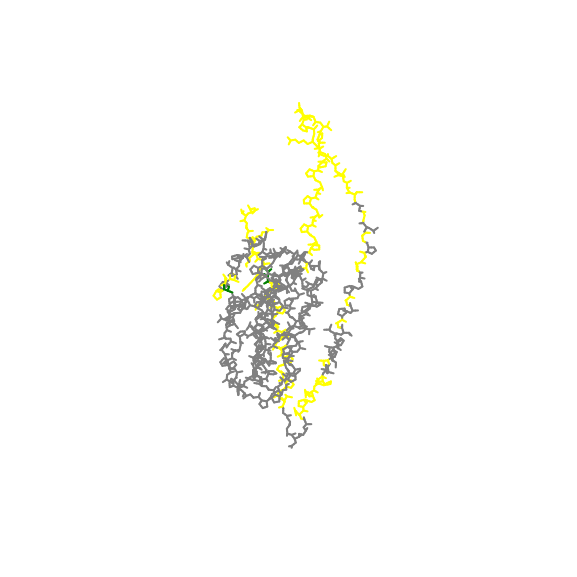

✅ Sauvé : outputs/3d_views/progen_cand_2.png


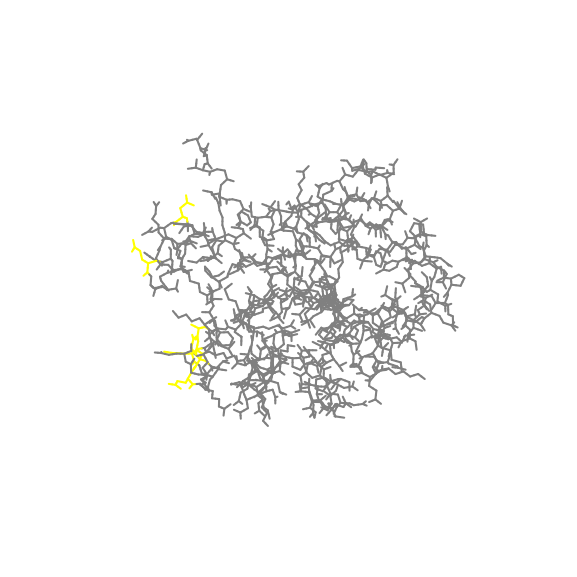

✅ Sauvé : outputs/3d_views/progen_cand_11.png


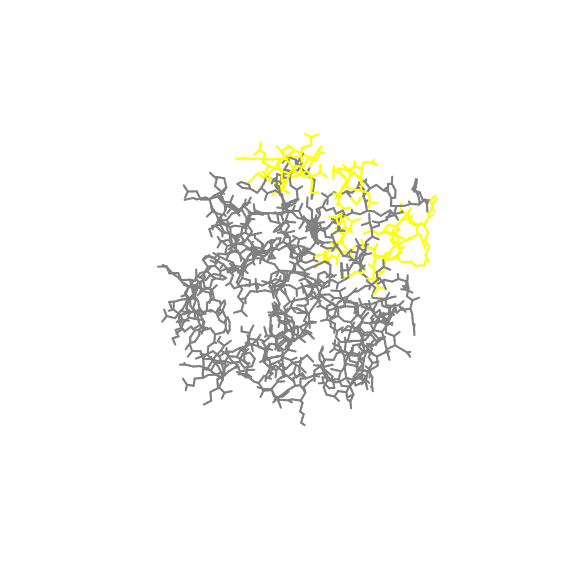

✅ Sauvé : outputs/3d_views/progen_cand_31.png


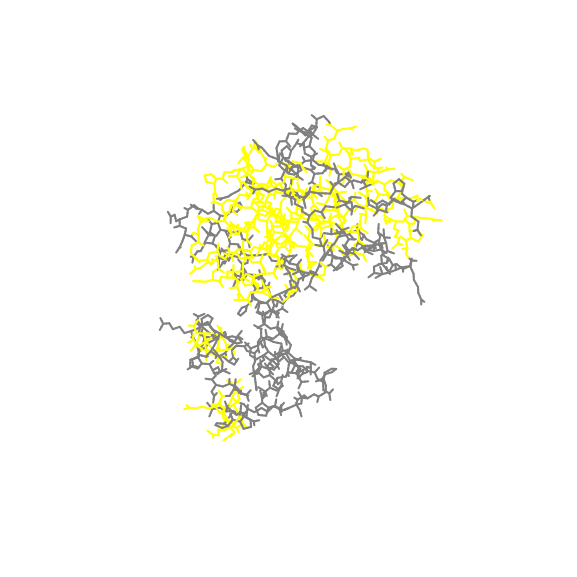

✅ Sauvé : outputs/3d_views/progen_cand_17.png


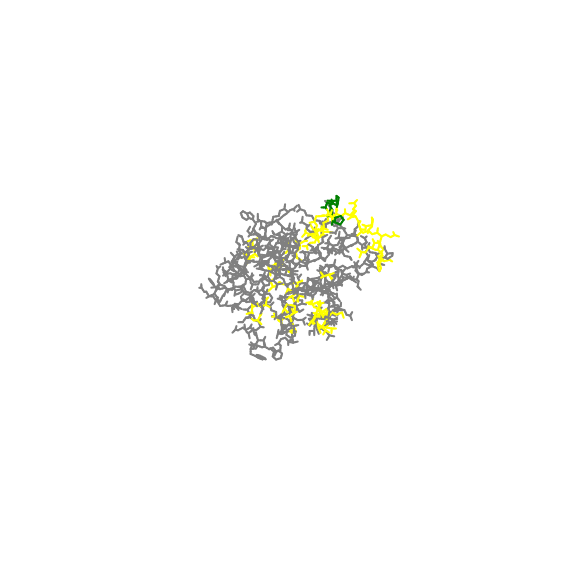

✅ Sauvé : outputs/3d_views/progen_cand_19.png


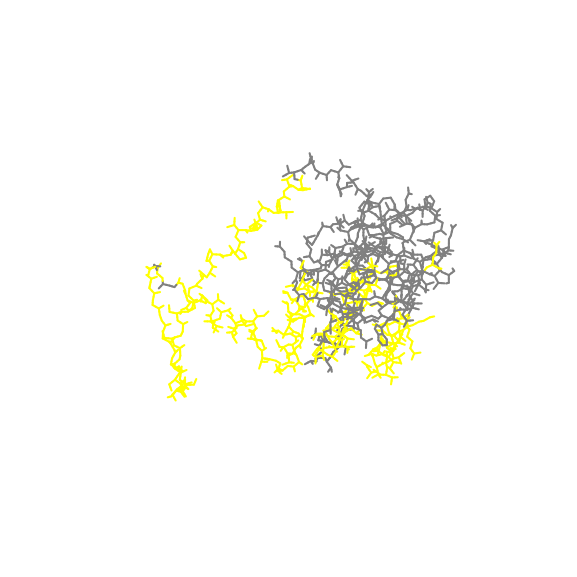

✅ Sauvé : outputs/3d_views/progen_cand_48.png


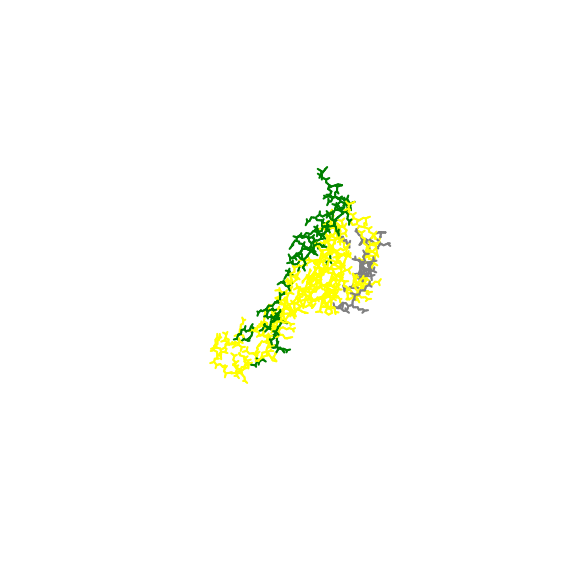

✅ Sauvé : outputs/3d_views/progen_cand_9.png


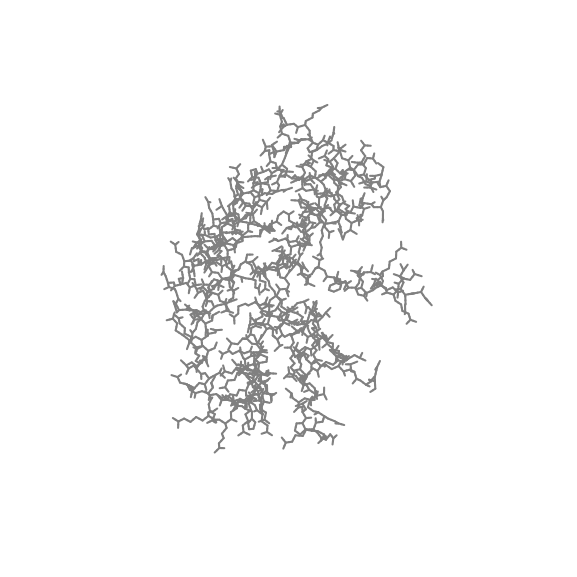

✅ Sauvé : outputs/3d_views/progen_cand_3.png


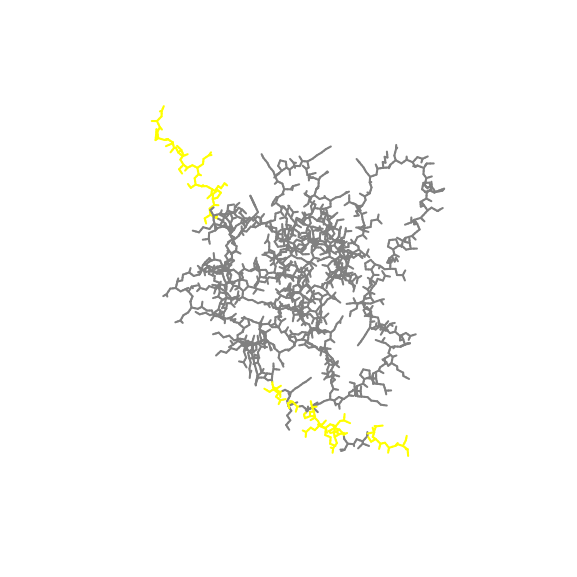

✅ Sauvé : outputs/3d_views/progen_cand_30.png


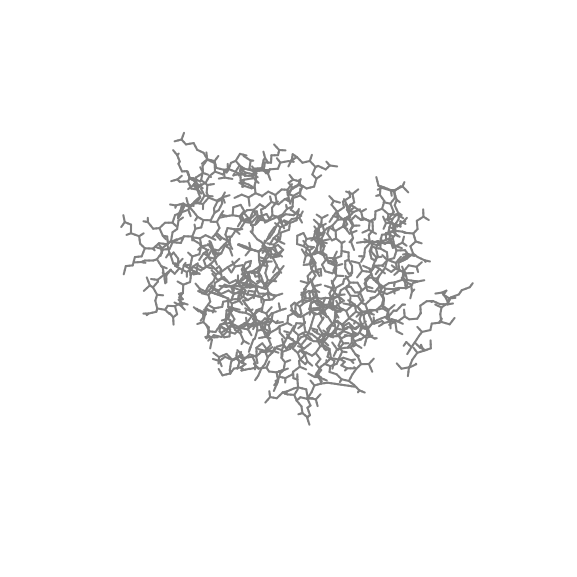

In [31]:
import os
import pandas as pd
import biotite.structure as struc
import biotite.structure.io as bsio
import biotite.structure.graphics as bsg
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Charger la table des candidats OK
tbl = pd.read_csv("outputs/top_candidates_with_pdb.csv", index_col="id")
ok = tbl.query("status=='ok'")

os.makedirs("outputs/3d_views", exist_ok=True)

def plddt_by_resi(pdb_path):
    """Retourne {résidu: score pLDDT} depuis un PDB ESMFold"""
    d = {}
    with open(pdb_path) as f:
        for L in f:
            if L.startswith("ATOM") and len(L) >= 66:
                try:
                    r = int(L[22:26])
                    b = float(L[60:66])
                    d.setdefault(r, []).append(b)
                except ValueError:
                    pass
    if not d:
        return {}
    mean = {r: sum(v)/len(v) for r, v in d.items()}
    scale = 100.0 if max(mean.values()) <= 1.5 else 1.0
    return {r: b*scale for r, b in mean.items()}

for i, r in ok.iterrows():
    pdb_path = r["pdb_path"]
    if not (os.path.exists(pdb_path) and os.path.getsize(pdb_path) > 0):
        continue

    # Charger la structure
    struct = bsio.load_structure(pdb_path)

    # Ajouter la connectivité
    struct.bonds = struc.connect_via_distances(struct)

    # Scores pLDDT → couleurs
    scores = plddt_by_resi(pdb_path)
    colors = []
    for atom in struct:
        score = scores.get(atom.res_id, 0)
        if score < 50:
            colors.append("gray")
        elif score < 70:
            colors.append("yellow")
        else:
            colors.append("green")

    # Affichage et sauvegarde
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    bsg.plot_atoms(ax, struct, line_width=1, colors=colors)
    ax.set_axis_off()

    out_path = f"outputs/3d_views/{i}.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

    print(f"✅ Sauvé : {out_path}")
    display(Image(filename=out_path))  # affiche directement dans Colab
